In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import pytz
from dateutil.parser import parse
import ipywidgets as widgets
from copy import deepcopy
from tqdm import tqdm
import imageio
from IPython import display
import plotly
import plotly.graph_objects as go
import itertools
import dateparser
import gc
import kaleido

In [3]:
#Parameters
seed = 42
symbol = 'BTCUSDT'

start_date = datetime(2022, 10, 1, tzinfo=pytz.utc)  # time period for analysis, must be timezone-aware
end_date = datetime(2023, 10, 31, tzinfo=pytz.utc)
time_buffer = timedelta(days=100)  # buffer before to pre-calculate SMA/EMA, best to set to max window
freq = '1d'

vbt.settings.portfolio['init_cash'] = 100.  # 100$
vbt.settings.portfolio['fees'] = 0.0025  # 0.25%
vbt.settings.portfolio['slippage'] = 0.0025  # 0.25%



In [4]:
cols = ['Open', 'High', 'Low', 'Close', 'Volume']
binance_data = vbt.BinanceData.download(
    symbol,
    start=start_date-time_buffer,
    end=end_date,
    interval=freq).get(cols)

binance_data = binance_data.astype(np.float64)
    
print(binance_data.shape)
print(binance_data.columns)

0it [00:00, ?it/s]

(495, 5)
Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


In [5]:
# Create a copy of data without time buffer
wobuf_mask = (binance_data.index >= start_date) & (binance_data.index <= end_date) # mask without buffer

ohlcv = binance_data.loc[wobuf_mask, :]

print(ohlcv.shape)

(395, 5)


In [6]:
# Plot the OHLC data
binance_data.vbt.ohlcv.plot(width=2000, height=1000)

FigureWidget({
    'data': [{'close': array([21110.13, 21237.69, 21491.19, ..., 34081.  , 34525.89, 34474.73]),
              'decreasing': {'line': {'color': '#d95f02'}},
              'high': array([21233.  , 21558.41, 21614.5 , ..., 34493.33, 34750.11, 34856.  ]),
              'increasing': {'line': {'color': '#1b9e76'}},
              'low': array([19890.07, 20736.72, 20906.62, ..., 33860.  , 33930.  , 34062.84]),
              'name': 'OHLC',
              'open': array([19988.  , 21110.12, 21237.68, ..., 33892.01, 34081.01, 34525.88]),
              'type': 'ohlc',
              'uid': 'a27f8279-1754-46dc-a555-28a7715f1c0a',
              'x': array([datetime.datetime(2022, 6, 23, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2022, 6, 24, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2022, 6, 25, 0, 0, tzinfo=datetime.timezone.utc), ...,
                          datetime.datetime(2023, 10, 28, 0, 0, tzinfo=da

In [7]:
fast_window = 30
slow_window = 80

In [8]:
# Pre-calculate running windows on data with time buffer
fast_ma = vbt.MA.run(binance_data['Open'], fast_window)
slow_ma = vbt.MA.run(binance_data['Open'], slow_window)

print(fast_ma.ma.shape)
print(slow_ma.ma.shape)



(495,)
(495,)


In [9]:
# Remove time buffer
fast_ma = fast_ma[wobuf_mask]
slow_ma = slow_ma[wobuf_mask]

# there should be no nans after removing time buffer
assert(~fast_ma.ma.isnull().any()) 
assert(~slow_ma.ma.isnull().any())

print(fast_ma.ma.shape)
print(slow_ma.ma.shape)

(395,)
(395,)


In [10]:
# Generate crossover signals
dmac_entries = fast_ma.ma_crossed_above(slow_ma)
dmac_exits = fast_ma.ma_crossed_below(slow_ma)

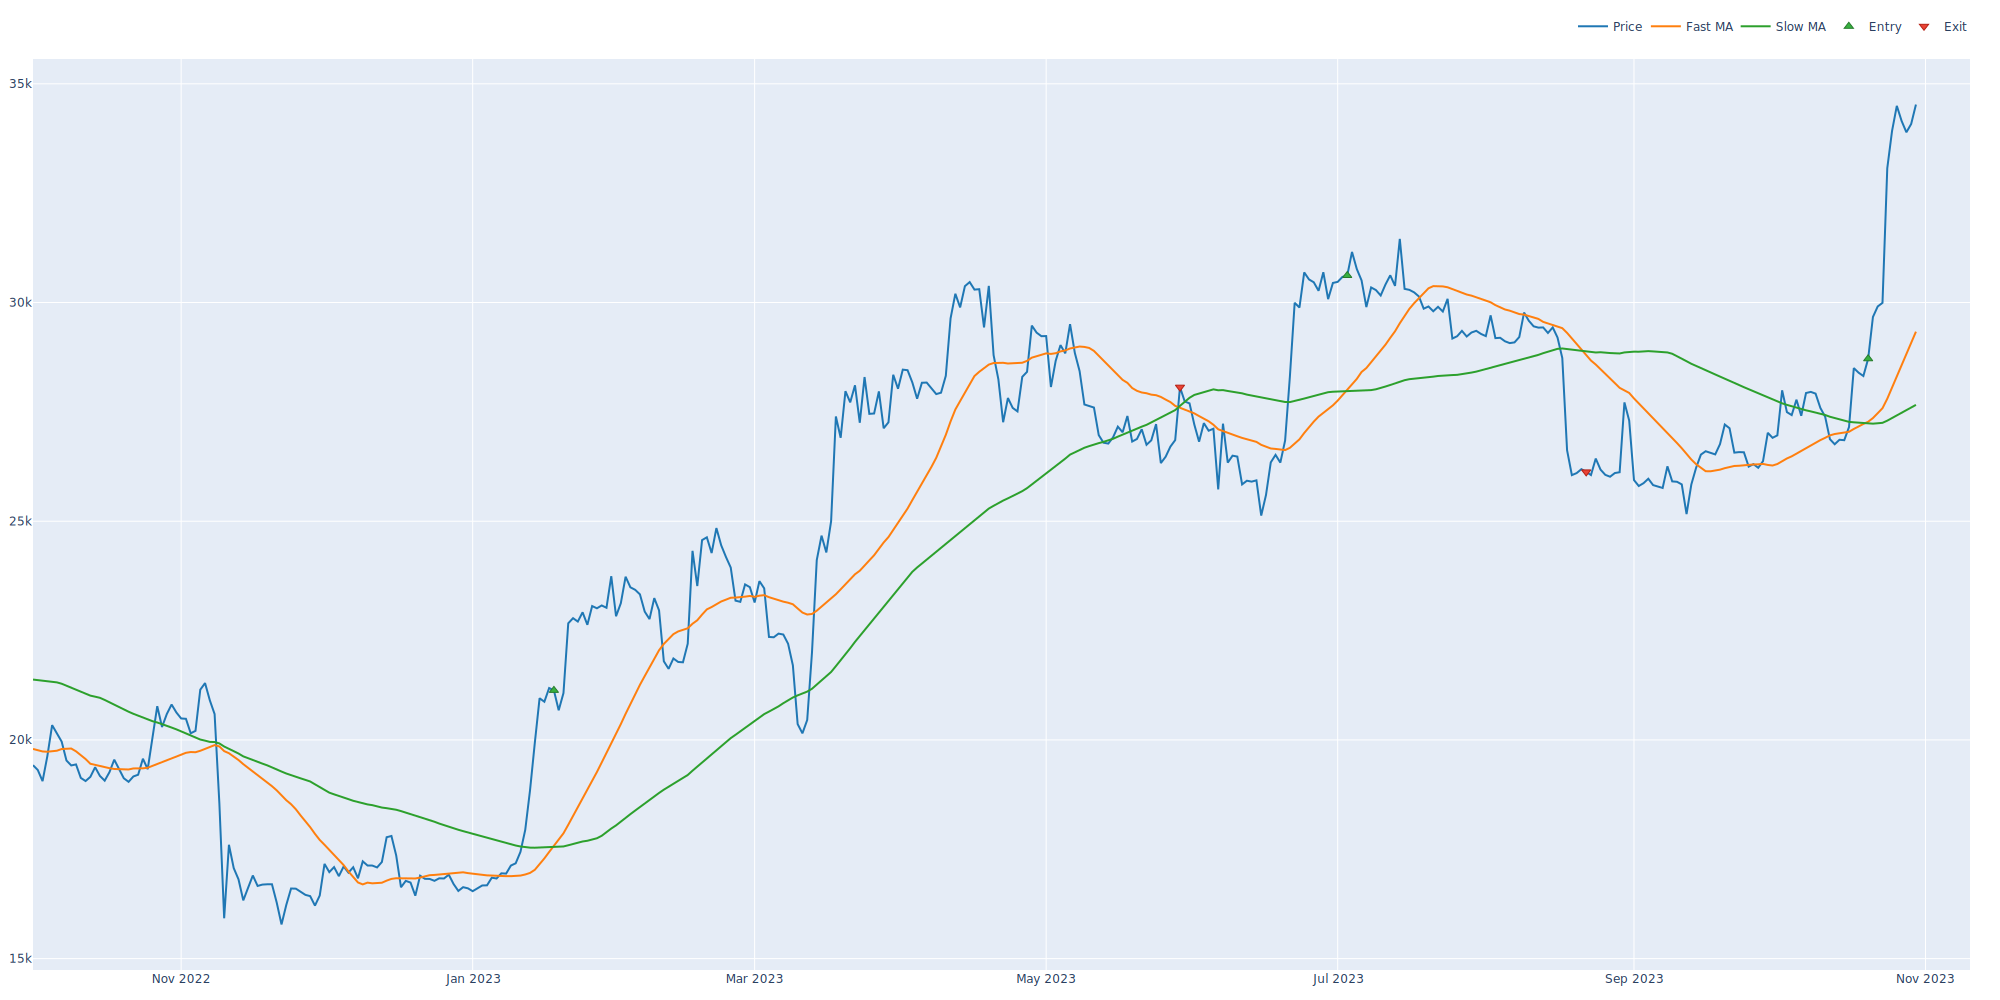

In [11]:
fig = ohlcv['Open'].vbt.plot(trace_kwargs=dict(name='Price'))
fig = fast_ma.ma.vbt.plot(trace_kwargs=dict(name='Fast MA'), fig=fig)
fig = slow_ma.ma.vbt.plot(trace_kwargs=dict(name='Slow MA'), fig=fig)
fig = dmac_entries.vbt.signals.plot_as_entry_markers(ohlcv['Open'], fig=fig)
fig = dmac_exits.vbt.signals.plot_as_exit_markers(ohlcv['Open'], fig=fig)

fig.show_svg(width=2000, height=1000)

In [12]:
# Signal stats
print(dmac_entries.vbt.signals.stats(settings=dict(other=dmac_exits)))

Start                       2022-10-01 00:00:00+00:00
End                         2023-10-30 00:00:00+00:00
Period                              395 days 00:00:00
Total                                               3
Rate [%]                                     0.759494
Total Overlapping                                   0
Overlapping Rate [%]                              0.0
First Index                 2023-01-18 00:00:00+00:00
Last Index                  2023-10-20 00:00:00+00:00
Norm Avg Index [-1, 1]                       0.299492
Distance -> Other: Min               50 days 00:00:00
Distance -> Other: Max              131 days 00:00:00
Distance -> Other: Mean              90 days 12:00:00
Distance -> Other: Std               57 days 06:36:56
Total Partitions                                    3
Partition Rate [%]                              100.0
Partition Length: Min                 1 days 00:00:00
Partition Length: Max                 1 days 00:00:00
Partition Length: Mean      

In [13]:
# Plot signals
fig = dmac_entries.vbt.signals.plot(trace_kwargs=dict(name='Entries'))
dmac_exits.vbt.signals.plot(trace_kwargs=dict(name='Exits'), fig=fig)

FigureWidget({
    'data': [{'mode': 'lines',
              'name': 'Entries',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'aad05dc7-4c8e-49df-8739-afbf6b6adcca',
              'x': array([datetime.datetime(2022, 10, 1, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2022, 10, 2, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2022, 10, 3, 0, 0, tzinfo=datetime.timezone.utc), ...,
                          datetime.datetime(2023, 10, 28, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 10, 29, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 10, 30, 0, 0, tzinfo=datetime.timezone.utc)],
                         dtype=object),
              'y': array([False, False, False, ..., False, False, False], dtype=object)},
             {'mode': 'lines',
              'name': 'Exits',
              'showlegend': 

In [14]:
# Build partfolio, which internally calculates the equity curve

# Volume is set to np.inf by default to buy/sell everything
# You don't have to pass freq here because our data is already perfectly time-indexed
dmac_pf = vbt.Portfolio.from_signals(ohlcv['Close'], dmac_entries, dmac_exits, freq=freq)

# Print stats
print(dmac_pf.stats())

Start                         2022-10-01 00:00:00+00:00
End                           2023-10-30 00:00:00+00:00
Period                                395 days 00:00:00
Start Value                                       100.0
End Value                                    127.133108
Total Return [%]                              27.133108
Benchmark Return [%]                          78.524257
Max Gross Exposure [%]                            100.0
Total Fees Paid                                1.463196
Max Drawdown [%]                              25.372524
Max Drawdown Duration                 199 days 00:00:00
Total Trades                                          3
Total Closed Trades                                   2
Total Open Trades                                     1
Open Trade PnL                                17.174294
Win Rate [%]                                       50.0
Best Trade [%]                                32.885575
Worst Trade [%]                              -17

In [15]:
# Plot trades
print(dmac_pf.trades.records)
dmac_pf.trades.plot(width=2000, height=1000)

   id  col      size  entry_idx   entry_price  entry_fees  exit_idx  \
0   0    0  0.004812        109  20729.163675    0.249377       240   
1   1    0  0.004241        275  31234.090500    0.331181       325   
2   2    0  0.003688        384  29743.212600    0.274212       394   

   exit_price  exit_fees        pnl    return  direction  status  parent_id  
0   27667.059   0.332841  32.803567  0.328856          0       1          0  
1   25990.860   0.275586 -22.844752 -0.172449          0       1          1  
2   34474.730   0.000000  17.174294  0.156579          0       0          2  


FigureWidget({
    'data': [{'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': '94085c15-bebf-46d8-9647-3cf3467d540d',
              'x': array([datetime.datetime(2022, 10, 1, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2022, 10, 2, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2022, 10, 3, 0, 0, tzinfo=datetime.timezone.utc), ...,
                          datetime.datetime(2023, 10, 28, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 10, 29, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 10, 30, 0, 0, tzinfo=datetime.timezone.utc)],
                         dtype=object),
              'y': array([19310.95, 19056.8 , 19629.08, ..., 34081.  , 34525.89, 34474.73])},
             {'customdata': array([[0, 0, 0.0048120910715611165, 0.24937655

In [16]:
# Now build portfolio for a "Hold" strategy
# Here we buy once at the beginning and sell at the end
hold_entries = pd.Series.vbt.signals.empty_like(dmac_entries)
hold_entries.iloc[0] = True
hold_exits = pd.Series.vbt.signals.empty_like(hold_entries)
hold_exits.iloc[-1] = True
hold_pf = vbt.Portfolio.from_signals(ohlcv['Close'], hold_entries, hold_exits)

In [17]:
# Equity
fig = dmac_pf.value().vbt.plot(trace_kwargs=dict(name='Value (DMAC)'))
hold_pf.value().vbt.plot(trace_kwargs=dict(name='Value (Hold)'), fig=fig)

FigureWidget({
    'data': [{'name': 'Value (DMAC)',
              'showlegend': True,
              'type': 'scatter',
              'uid': '42d42418-b52a-41ec-b36e-99cdbd5f6b2d',
              'x': array([datetime.datetime(2022, 10, 1, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2022, 10, 2, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2022, 10, 3, 0, 0, tzinfo=datetime.timezone.utc), ...,
                          datetime.datetime(2023, 10, 28, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 10, 29, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2023, 10, 30, 0, 0, tzinfo=datetime.timezone.utc)],
                         dtype=object),
              'y': array([100.        , 100.        , 100.        , ..., 125.68114247,
                          127.32177166, 127.13310797])},
             {'name': 'Value (Hold)',
              'showlegen

In [18]:
min_window = 2
max_window = 100

In [30]:
perf_metrics = ['total_return', 'positions.win_rate', 'positions.expectancy', 'max_drawdown']
perf_metric_names = ['Total return', 'Win rate', 'Expectancy', 'Max drawdown']

windows_slider = widgets.IntRangeSlider(
    value=[fast_window, slow_window],
    min=min_window,
    max=max_window,
    step=1,
    layout=dict(width='500px'),
    continuous_update=True
)
dmac_fig = None
dmac_img = widgets.Image(
    format='png',
    width=vbt.settings['plotting']['layout']['width'],
    height=vbt.settings['plotting']['layout']['height']
)
metrics_html = widgets.HTML()

def on_value_change(value):
    global dmac_fig
    
    # Calculate portfolio
    fast_window, slow_window = value['new']
    fast_ma = vbt.MA.run(binance_data['Open'], fast_window)
    slow_ma = vbt.MA.run(binance_data['Open'], slow_window)
    fast_ma = fast_ma[wobuf_mask]
    slow_ma = slow_ma[wobuf_mask]
    dmac_entries = fast_ma.ma_crossed_above(slow_ma)
    dmac_exits = fast_ma.ma_crossed_below(slow_ma)
    dmac_pf = vbt.Portfolio.from_signals(ohlcv['Close'], dmac_entries, dmac_exits)

    # Update figure
    if dmac_fig is None:
        dmac_fig = ohlcv['Open'].vbt.plot(trace_kwargs=dict(name='Price'))
        fast_ma.ma.vbt.plot(trace_kwargs=dict(name='Fast MA'), fig=dmac_fig)
        slow_ma.ma.vbt.plot(trace_kwargs=dict(name='Slow MA'), fig=dmac_fig)
        dmac_entries.vbt.signals.plot_as_entry_markers(ohlcv['Open'], fig=dmac_fig)
        dmac_exits.vbt.signals.plot_as_exit_markers(ohlcv['Open'], fig=dmac_fig)
    else:
        with dmac_fig.batch_update():
            dmac_fig.data[1].y = fast_ma.ma
            dmac_fig.data[2].y = slow_ma.ma
            dmac_fig.data[3].x = ohlcv['Open'].index[dmac_entries]
            dmac_fig.data[3].y = ohlcv['Open'][dmac_entries]
            dmac_fig.data[4].x = ohlcv['Open'].index[dmac_exits]
            dmac_fig.data[4].y = ohlcv['Open'][dmac_exits]
    dmac_img.value = dmac_fig.to_image(format="png")
    
    # Update metrics table
    sr = pd.Series([dmac_pf.deep_getattr(m) for m in perf_metrics], 
                   index=perf_metric_names, name='Performance')
    metrics_html.value = sr.to_frame().style.set_properties(**{'text-align': 'right'}).to_html()
    
windows_slider.observe(on_value_change, names='value')
on_value_change({'new': windows_slider.value})

dashboard = widgets.VBox([
    widgets.HBox([widgets.Label('Fast and slow window:'), windows_slider]),
    dmac_img,
    metrics_html
])
dashboard

In [31]:
dashboard.close()

In [32]:
gc.collect()

153208

In [22]:
# Pre-calculate running windows on data with time buffer
fast_ma, slow_ma = vbt.MA.run_combs(
    binance_data['Open'], np.arange(min_window, max_window+1), 
    r=2, short_names=['fast_ma', 'slow_ma'])

print(fast_ma.ma.shape)
print(slow_ma.ma.shape)
print(fast_ma.ma.columns)
print(slow_ma.ma.columns)

(495, 4851)
(495, 4851)
Index([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
       ...
       96, 96, 96, 96, 97, 97, 97, 98, 98, 99],
      dtype='int64', name='fast_ma_window', length=4851)
Index([  3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
       ...
        97,  98,  99, 100,  98,  99, 100,  99, 100, 100],
      dtype='int64', name='slow_ma_window', length=4851)


In [23]:
# Remove time buffer
fast_ma = fast_ma[wobuf_mask]
slow_ma = slow_ma[wobuf_mask]

print(fast_ma.ma.shape)
print(slow_ma.ma.shape)

(395, 4851)
(395, 4851)


In [24]:
# We perform the same steps, but now we have 4851 columns instead of 1
# Each column corresponds to a pair of fast and slow windows
# Generate crossover signals
dmac_entries = fast_ma.ma_crossed_above(slow_ma)
dmac_exits = fast_ma.ma_crossed_below(slow_ma)

print(dmac_entries.columns) # the same for dmac_exits

MultiIndex([( 2,   3),
            ( 2,   4),
            ( 2,   5),
            ( 2,   6),
            ( 2,   7),
            ( 2,   8),
            ( 2,   9),
            ( 2,  10),
            ( 2,  11),
            ( 2,  12),
            ...
            (96,  97),
            (96,  98),
            (96,  99),
            (96, 100),
            (97,  98),
            (97,  99),
            (97, 100),
            (98,  99),
            (98, 100),
            (99, 100)],
           names=['fast_ma_window', 'slow_ma_window'], length=4851)


In [25]:
# Build portfolio
dmac_pf = vbt.Portfolio.from_signals(ohlcv['Close'], dmac_entries, dmac_exits)

In [26]:
# Calculate performance of each window combination
dmac_perf = dmac_pf.deep_getattr('total_return')

print(dmac_perf.shape)
print(dmac_perf.index)

(4851,)
MultiIndex([( 2,   3),
            ( 2,   4),
            ( 2,   5),
            ( 2,   6),
            ( 2,   7),
            ( 2,   8),
            ( 2,   9),
            ( 2,  10),
            ( 2,  11),
            ( 2,  12),
            ...
            (96,  97),
            (96,  98),
            (96,  99),
            (96, 100),
            (97,  98),
            (97,  99),
            (97, 100),
            (98,  99),
            (98, 100),
            (99, 100)],
           names=['fast_ma_window', 'slow_ma_window'], length=4851)


In [27]:
dmac_perf.idxmax() # your optimal window combination

(49, 55)

In [28]:
# Convert this array into a matrix of shape (99, 99): 99 fast windows x 99 slow windows
dmac_perf_matrix = dmac_perf.vbt.unstack_to_df(symmetric=True, 
    index_levels='fast_ma_window', column_levels='slow_ma_window')

print(dmac_perf_matrix.shape)

(99, 99)


In [29]:
dmac_perf_matrix.vbt.heatmap(
    xaxis_title='Slow window', 
    yaxis_title='Fast window')

/home/figa/.local/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



FigureWidget({
    'data': [{'colorscale': [[0.0, '#0d0887'], [0.1111111111111111, '#46039f'],
                             [0.2222222222222222, '#7201a8'], [0.3333333333333333,
                             '#9c179e'], [0.4444444444444444, '#bd3786'],
                             [0.5555555555555556, '#d8576b'], [0.6666666666666666,
                             '#ed7953'], [0.7777777777777778, '#fb9f3a'],
                             [0.8888888888888888, '#fdca26'], [1.0, '#f0f921']],
              'hoverongaps': False,
              'type': 'heatmap',
              'uid': 'a6db4788-4433-42f3-a140-85534cf9a0f5',
              'x': array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
                           16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
                           30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
                           44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  